In [5]:
%cd /home/jovyan/work/solar-pv

/home/jovyan/work/solar-pv


In [2]:
!pwd

/Users/N1/Desktop/Kaggle Report


In [3]:
!ls -ltr

total 2072
-rw-rw-r--@    1 Nathan  staff    9990 Feb  3 17:25 sample_submission.csv
-rw-rw-r--@    1 Nathan  staff   10900 Feb  3 17:25 labels_training.csv
drwxr-xr-x   560 Nathan  staff   17920 Mar  2 16:49 testing
drwxr-xr-x  1502 Nathan  staff   48064 Mar  2 16:59 training
-rw-r--r--@    1 Nathan  staff  791616 Mar  2 20:58 Trial.ipynb
-rw-r--r--@    1 Nathan  staff  240286 Mar  2 21:02 cnn_final.ipynb


In [5]:
!mkdir solar-pv/

In [6]:
!mkdir solar-pv/data/

In [57]:
!rm -rf ~/work/solar-pv/data/
!cp -R ~/work/solar-pv/data_bkp/ ~/work/solar-pv/data/

In [30]:
!rm -rf ./data/training/.ipynb_checkpoints/

In [1]:
import shutil
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import sklearn.metrics as metrics
from skimage.feature import hog
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from ipywidgets import IntProgress
import ipywidgets
warnings.filterwarnings('ignore')

In [2]:
dir_train_images  = './data/'
dir_train_labels  = './data/labels_training.csv'

In [3]:
def load_labels(dir_labels):
    labels = dict()
    cnt = 0
    
    with open (dir_labels) as f:
        for i in f:
            cnt += 1
            if cnt == 1:
                continue
            i = i.split(',')
            labels[int(i[0])] = int(i[1][0])

    return labels

In [5]:
%cd solar-pv

/Users/N1/Desktop/Kaggle Report/solar-pv


In [6]:
labels = load_labels(dir_train_labels)

In [7]:
def split_train_val(labels):
    val_dic = {}
    np.random.seed(100)
    val_idx = np.random.randint(0, 1500, 328)
    print(len(val_idx))

    for idx in val_idx:
        val_dic[idx] = labels[idx] 
    #val_labels = [labels[i] for i in labels.keys() if i in val_idx]
    return val_dic

In [8]:
vals_dics= split_train_val(labels)

328


In [9]:
len(vals_dics) #bluffed

300

In [10]:
def load_data(path, vals_dics, labels):
    trainig_path = path + 'training/'
    validation_path = path + 'validation/'
    
    files = os.listdir(trainig_path)
    print ('files', len(files))

    f1 = path
    
    t_folder, f_folder = 'is_true/', 'is_false/'
    
    if not os.path.exists(f1):
        os.makedirs(f1)

    if not os.path.exists(f1 + 'training/'):
        os.makedirs(f1 + 'training/')
    
    if not os.path.exists(f1 + 'training/' + t_folder):
        os.makedirs(f1 + 'training/' + t_folder)

    if not os.path.exists(f1 + 'training/' + f_folder):
        os.makedirs(f1 + 'training/' + f_folder)
        
    if not os.path.exists(f1 + 'validation/'):
        os.makedirs(f1 + 'validation/')
        
    if not os.path.exists(f1 + 'validation/' + t_folder):
        os.makedirs(f1 + 'validation/' + t_folder)

    if not os.path.exists(f1 + 'validation/' + f_folder):
        os.makedirs(f1 + 'validation/' + f_folder)
    
    for i in range(len(files)):
        fi = files[i]
        #print(i)
        #print(fi[:-4])
        idx = int(fi[:-4])
        
        move_path = trainig_path
        
        if idx in vals_dics.keys():
            move_path = validation_path
            
        li = labels[idx]
        if li == 1:
            shutil.move(trainig_path + fi , move_path + t_folder + fi)
            print(trainig_path + fi , move_path + t_folder + fi)
        elif li == 0:
            shutil.move(trainig_path + fi , move_path + f_folder + fi)
            print (trainig_path + fi , move_path + f_folder + fi)
        else:
            exit(-1)

In [73]:
!rm -rf ~/work/solar-pv/data/
!cp -R ~/work/solar-pv/data_bkp/ ~/work/solar-pv/data/



files 1500
./data/training/1127.tif ./data/training/is_true/1127.tif
./data/training/1128.tif ./data/training/is_true/1128.tif
./data/training/1129.tif ./data/training/is_false/1129.tif
Path is VALIDATION
./data/training/113.tif ./data/validation/is_true/113.tif
./data/training/1130.tif ./data/training/is_false/1130.tif
./data/training/1131.tif ./data/training/is_false/1131.tif
./data/training/1132.tif ./data/training/is_false/1132.tif
./data/training/1133.tif ./data/training/is_false/1133.tif
./data/training/1134.tif ./data/training/is_false/1134.tif
./data/training/1135.tif ./data/training/is_false/1135.tif
./data/training/1136.tif ./data/training/is_true/1136.tif
./data/training/1137.tif ./data/training/is_true/1137.tif
./data/training/1074.tif ./data/training/is_true/1074.tif
./data/training/1075.tif ./data/training/is_true/1075.tif
Path is VALIDATION
./data/training/1076.tif ./data/validation/is_false/1076.tif
Path is VALIDATION
./data/training/1077.tif ./data/validation/is_false/

In [11]:
data_transforms = {
'train': transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [20]:
data_dir = './data/'
image_datasets = datasets.ImageFolder(data_dir + 'training/', data_transforms['train'])
val_datasets = datasets.ImageFolder(data_dir + 'validation/', data_transforms['val'])

dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=30, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_datasets, batch_size=30, shuffle=False, num_workers=4)

In [25]:
def model():
    return models.resnet18(pretrained=True)

def get_optimizer(model_ft):
    return optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [28]:
def fit(num_epoch=20):

    model_ft = model()
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = model_ft
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model_ft)

    y_preds = []
    y_label = []
        
    for epoch in range(num_epoch):
        pred_l = []
        y_l = []
        for data in dataloader:
            model_ft.train()
            x, y = data
            x = Variable(x)
            y = Variable(y)
            pred = model_ft(x)

            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            pred_l.append(pred[:, -1].data.cpu().numpy() )
            y_l.append(y.data.cpu().numpy() )

        pred_l = np.concatenate(pred_l)
        y_l = np.concatenate(y_l)
        print (epoch, 'train', round(metrics.roc_auc_score(y_l, pred_l), 2))

        pred_l = []
        y_l = []
        pred_result_l = []

        for data in valloader:
            model_ft.eval()
            x, y = data
            x = Variable(x)
            y = Variable(y)
            pred = model_ft(x)
            _, pred_result = torch.max(pred, 1)
            
            pred_result_l.append(pred_result.data.cpu().numpy())
            pred_l.append(pred[:, -1].data.cpu().numpy())
            y_l.append(y.data.cpu().numpy())
        
        pred_l = np.concatenate(pred_l)
        y_l = np.concatenate(y_l)
        pred_result_l = np.concatenate(pred_result_l)
        
        y_preds = pred_l
        y_label = y_l
        y_pred_result = pred_result_l
        
        print (epoch, 'val', round(metrics.roc_auc_score(y_l, pred_l), 2))
    
    print('Fnished Epochs')
    return y_preds, y_label, y_pred_result

In [29]:
from ipywidgets import IntProgress
y_preds, y_label, y_pred_result = fit(20)

0 train 0.84
0 val 0.88
1 train 0.91
1 val 0.98
2 train 0.94
2 val 0.98
3 train 0.96
3 val 0.99
4 train 0.97
4 val 0.99
5 train 0.97
5 val 0.99
6 train 0.98
6 val 0.99
7 train 0.98
7 val 0.99
8 train 0.98
8 val 0.99
9 train 0.99
9 val 0.99
10 train 0.98
10 val 0.98
11 train 0.98
11 val 0.99
12 train 0.98
12 val 0.99
13 train 0.98
13 val 0.99
14 train 0.99
14 val 1.0
15 train 0.99
15 val 0.99
16 train 0.98
16 val 0.99
17 train 0.98
17 val 0.99
18 train 0.98
18 val 0.99
19 train 0.99
19 val 0.99
Fnished Epochs


In [24]:
load_data(dir_train_images, vals_dics, labels)

files 2


ValueError: invalid literal for int() with base 10: 'is_f'

In [20]:
df = pd.DataFrame()
df['y_labels'] = list(y_labels)
df['y_pred_result'] = list(y_pred_result)

NameError: name 'y_labels' is not defined

In [35]:
df[df.y_labels!=df.y_pred_result]

,y_labels,y_pred_result
57,0,1
166,0,1
177,0,1
211,1,0
230,1,0
256,1,0
257,1,0
259,1,0
282,1,0


In [36]:
invalid_idx = [57,166,177,211,230,256,257,259,282]
for idx in invalid_idx:
    print(list(vals_dics.keys())[idx])

475
998
613
1076
294
1315
1050
132
1014


In [23]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Random Guess')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.title('ROC curve')
    plt.tight_layout()

In [22]:
plot_roc(y_labels, y_preds)

NameError: name 'y_labels' is not defined

In [162]:
preds_siged = 1/(1+np.exp(-preds))
preds_siged

array([2.35446766e-02, 8.07068273e-02, 2.96662211e-01, 8.78148247e-03,
       4.55356687e-02, 3.68639350e-01, 8.43322039e-01, 8.04590806e-02,
       2.99051050e-02, 2.35358924e-01, 8.04474428e-02, 1.63646460e-01,
       7.07257316e-02, 1.31332666e-01, 6.92975596e-02, 2.17375517e-01,
       3.60777974e-01, 2.25323979e-02, 2.66320050e-01, 9.25395489e-02,
       3.24416339e-01, 1.66894682e-02, 8.47978294e-02, 3.45940841e-03,
       1.53115824e-01, 2.82388419e-01, 3.60494852e-02, 9.75333229e-02,
       4.39246148e-02, 3.04339349e-01, 1.35901636e-02, 2.03730270e-01,
       2.77694184e-02, 9.44514349e-02, 2.21092716e-01, 6.40672445e-02,
       1.83493271e-01, 1.97019637e-01, 4.35500080e-03, 2.95311004e-01,
       1.31983712e-01, 8.70489240e-01, 5.52594140e-02, 8.45835358e-02,
       7.50624947e-03, 3.47985849e-02, 5.59441410e-02, 7.92528316e-02,
       1.09994277e-01, 2.24180177e-01, 6.72897339e-01, 1.73060015e-01,
       1.45433813e-01, 4.87197191e-03, 8.47021304e-03, 4.83147018e-02,
      

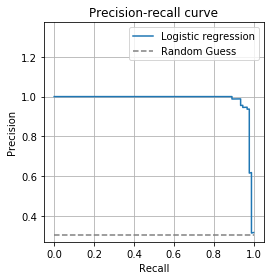

In [27]:
precision, recall, thres = precision_recall_curve(y_labels, y_preds, pos_label=1)
plt.plot(recall, precision, label='Logistic regression')

pos_prop = len(y_labels[y_labels == 1])/len(y_labels)
plt.plot([0,1],[pos_prop,pos_prop], '--', color = 'grey', label = 'Random Guess')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.title('Precision-recall curve')
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


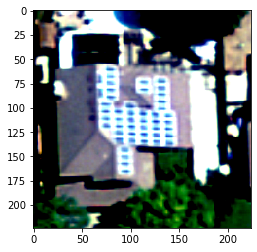

In [178]:
x_np = x.numpy()
sample1 = x_np[0]
sample1 = np.swapaxes(sample1,0,2)

plt.imshow(sample1)